# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Sources

Decided to go with the astromodels package as python3 branch is working well.

To install: 
```
pip install git+https://github.com/giacomov/astromodels.git@py2to3
```

In [2]:
from source.source import *
from astromodels.functions.functions import Powerlaw
from astromodels import Model

In [3]:
# Single source
source = PointSource('point', ra=123, dec=-30, redshift=0.1, spectral_shape=Powerlaw())
source.position.get_ra()
source.redshift

0.1

In [4]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'
source_list = TestSourceList(source_file, spectral_shape=Powerlaw())

# Select sources below zth = 1
zth = 1.0
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1
diffuse_bg = DiffuseSource('diffuse_bg', zth, spectral_shape=Powerlaw())
source_list.add(diffuse_bg)

In [5]:
source_list.sources[0].position.dec.value

-19.438230205811653

In [6]:
source_list.sources[-1].redshift
source_list.N

38

In [7]:
# Could also use an astromodels model
source_model = Model(*source_list.sources)

## Effective area

In [27]:
from detector_model import NorthernTracksDetectorModel, NorthernTracksEffectiveArea
from backend.stan_generator import (StanFileGenerator, 
                                    StanGenerator, 
                                    FunctionsContext, Include, 
                                    DataContext, TransformedDataContext,
                                    StringExpression, ForLoopContext)
from backend.variable_definitions import ForwardVariableDef, ForwardArrayDef

In [9]:
# helper functions
def power_law_integral(Emin, Emax, alpha):
    return np.power(Emax, 1-alpha) - np.power(Emin, 1-alpha)

In [10]:
# Precomputation of eps(alpha)
with StanGenerator() as cg:
    ntAeff = NorthernTracksEffectiveArea()
    Aeff = ntAeff._eff_area
    tE_bin_edges = ntAeff._tE_bin_edges
    cosz_bin_edges = ntAeff._cosz_bin_edges

In [15]:
alpha_grid = np.linspace(1, 4)
Emin = 1e5 # GeV
m_to_cm = 100 # cm

eps_grid = []
for source in source_list.sources:
    z = source.redshift
    eps_grid_i = np.zeros(len(alpha_grid))

    for i, alpha in enumerate(alpha_grid):
        
        if isinstance(source, PointSource):

            dec = source.position.dec.value
            cosz = -np.sin(dec)
                
            j = 0 
            for Em, EM in zip(tE_bin_edges[:-1], tE_bin_edges[1:]):
                integ = power_law_integral(Em, EM, alpha) * (1+z) * (1/Emin**2)
                if cosz < cosz_bin_edges[0] or cosz > cosz_bin_edges[-1]:
                    aeff = 0
                else:
                    aeff = Aeff[j][np.digitize(cosz, cosz_bin_edges)-1] * m_to_cm**2
                eps_grid_i[i] += integ * aeff
                j += 1

        if isinstance(source, DiffuseSource):
            
            j = 0
            k = 0
            for Em, EM in zip(tE_bin_edges[:-1], tE_bin_edges[1:]):
                for czm, czM in zip(cosz_bin_edges[:-1], cosz_bin_edges[1:]): 
                    E_integ = power_law_integral(Em, EM, alpha) * (1+z) * (1/Emin**2)
                    ang_integ = (czM - czm) * 2*np.pi
                    aeff = Aeff[j][k] * m_to_cm**2
                    eps_grid_i[i] += E_integ * ang_integ * aeff
                    
        eps_grid.append(eps_grid_i)
                

In [16]:
np.shape(eps_grid)

(1900, 50)

In [17]:
# Generate functions that can be included
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd = NorthernTracksDetectorModel()    
    cg.generate_files()

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


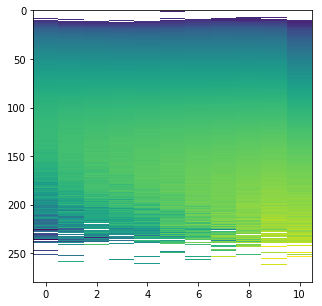

In [18]:
def test_thing(my_input):
    with StanGenerator() as cg:
        Aeff = my_input()
        Aeff_vals = Aeff._eff_area
    return Aeff_vals

aeff_vals = test_thing(NorthernTracksEffectiveArea)
fig, ax = plt.subplots()
fig.set_size_inches((5, 5))
ax.imshow(np.log10(aeff_vals), aspect='auto')

## Generate Stan code for simulation


In [28]:
e_true_name = "e_trues"
e_reco_name = "e_recos"
true_dir_name = "true_dirs"
reco_zenith_name = "reco_zeniths"

with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        ntd = NorthernTracksDetectorModel()
            
    with DataContext() as dc:
        
        # Sources
        Nsrc = ForwardVariableDef("Ns", "int")
        Nsrc_1p = ForwardVariableDef("Ns+1", "int")
        Nsrc_str = ["[", Nsrc, "]"]
        Nsrc_1p_str = ["[", Nsrc_1p, "]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Nsrc_str)
        distance = ForwardArrayDef("D", "vector", Nsrc_str)
        redshift = ForwardArrayDef("z", "vector", Nsrc_1p_str)
        
        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Emin_tracks = ForwardVariableDef("Emin_tracks", "real")
        
        # Flux
        source_luminosity = ForwardVariableDef("Q", "real")
        background_flux = ForwardVariableDef("F0", "real")
        
    with TransformedDataContext() as tdc:
        flux = ForwardArrayDef("F", "vector", Nsrc_1p_str)
        total_flux = ForwardVariableDef("FT", "real")
        associated_fraction = ForwardVariableDef("f", "real")
        exposure_weights = ForwardArrayDef("w_exposure", "simplex", Nsrc_1p_str)
        expected_number = ForwardVariableDef("Nex", "real")
        number = ForwardVariableDef("N", "int")
        exposure_factor = ForwardArrayDef("eps", "vector", Nsrc_1p_str)
        
        Mpc_to_m = ForwardVariableDef("Mpc_to_m", "real")
        Mpc_to_m << StringExpression("3.086e22")
        
        with ForLoopContext(1, Nsrc, "k") as k:
            flux[k] << StringExpression(["4 * pi() * pow(", 
                                         distance[k], " * ", Mpc_to_m, ", 2)"])
            